In [22]:
import sys
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
import seaborn as sns

sns.set_theme(color_codes=True)
import random
import joblib

sys.path.insert(0, ".././0.data-download/scripts/")
from data_loader import load_train_test_data, load_data
from matplotlib.pyplot import figure, gcf
from sklearn.decomposition import PCA
from tensorflow import keras
from vae import VAE
from keras.models import Model, Sequential

In [23]:
random.seed(18)
print(random.random())

0.18126486333322134


In [24]:
# load the data
data_directory = pathlib.Path("../0.data-download/data")
train_init, test_init, gene_stats = load_train_test_data(
    data_directory, train_or_test="all", load_gene_stats=True
)

In [25]:
# drop the string values
train_df = train_init.drop(columns=["DepMap_ID", "age_and_sex"])
test_df = test_init.drop(columns=["DepMap_ID", "age_and_sex"])

In [26]:
# subsetting the genes
# create dataframe containing the 1000 genes with the largest variances and their corresponding gene label and extract the gene labels
largest_var_df = gene_stats.nlargest(1000, "variance")
gene_list = largest_var_df["gene_ID"].tolist()
gene_list

# create new training and testing dataframes that contain only the corresponding genes
subset_train_df = train_df.filter(gene_list, axis=1)
subset_test_df = test_df.filter(gene_list, axis=1)

In [27]:
print(subset_train_df.shape)
subset_train_df.head(3)

(751, 1000)


,GPX4 (2879),CCND1 (595),EP300 (2033),CDK6 (1021),TXNRD1 (7296),ITGAV (3685),TYMS (7298),RIC1 (57589),STX4 (6810),SDHB (6390),...,GPR61 (83873),ENSA (2029),NCOA6 (23054),RAC1 (5879),MRPS22 (56945),VCL (7414),EXOC2 (55770),FABP5 (2171),LSM10 (84967),IFITM2 (10581)
0,0.940381,0.990926,0.000553,0.359180,0.967980,0.990922,0.137612,0.729464,0.059158,0.035206,...,0.716783,0.286511,0.031247,0.998153,0.100166,0.881757,0.464951,0.036607,0.860684,0.178508
1,0.977704,0.978002,0.893363,0.404650,0.934863,0.968326,0.147697,0.922680,0.038857,0.029896,...,0.404220,0.370852,0.773730,0.909492,0.447132,0.448574,0.343470,0.786135,0.276141,0.195710
2,0.939975,0.039721,0.933913,0.944452,0.819059,0.102276,0.983097,0.387890,0.087310,0.952576,...,0.332486,0.448683,0.133314,0.350446,0.832741,0.145942,0.052924,0.868234,0.294384,0.419293


In [28]:
print(subset_test_df.shape)
subset_test_df.head(3)

(133, 1000)


,GPX4 (2879),CCND1 (595),EP300 (2033),CDK6 (1021),TXNRD1 (7296),ITGAV (3685),TYMS (7298),RIC1 (57589),STX4 (6810),SDHB (6390),...,GPR61 (83873),ENSA (2029),NCOA6 (23054),RAC1 (5879),MRPS22 (56945),VCL (7414),EXOC2 (55770),FABP5 (2171),LSM10 (84967),IFITM2 (10581)
0,0.958795,0.956562,0.065556,0.652089,0.013551,0.904227,0.079523,0.056452,0.163706,0.010778,...,0.830012,0.675331,0.888964,0.947275,0.428821,0.802744,0.226727,0.940660,0.337393,0.147007
1,0.474103,0.995809,0.493091,0.324534,0.825609,0.280193,0.948674,0.968149,0.709961,0.921780,...,0.752857,0.219295,0.181090,0.934329,0.912023,0.273095,0.241361,0.642029,0.931141,0.564838
2,0.999218,0.999975,0.001974,0.115929,0.387753,0.200597,0.731629,0.994617,0.118876,0.099596,...,0.462767,0.448056,0.027778,0.337720,0.905973,0.166793,0.464052,0.399451,0.971522,0.519509


In [29]:
encoder_architecture = []
decoder_architecture = []

In [30]:
# These optimal parameter values were fetched by running "optimize_hyperparameters.py" and then running "fetch_hyper_params.ipynb" to learn the best hyperparamaters to use in the VAE.
trained_vae = VAE(
    input_dim=subset_train_df.shape[1],
    latent_dim=100,
    batch_size=112,
    encoder_batch_norm=True,
    epochs=905,
    learning_rate=0.005,
    encoder_architecture=encoder_architecture,
    decoder_architecture=decoder_architecture,
    beta=10,
    lam=0,
    verbose=True,
)

trained_vae.compile_vae()

In [31]:
trained_vae.train(x_train=subset_train_df, x_test=subset_test_df)

Epoch 1/905
7/7 [==============================] - 1s 70ms/step - loss: 965.5378 - recon: 494.8785 - kl: 470.6592 - val_loss: 10756.2891 - val_recon: 3845.3132 - val_kl: 6910.9756
Epoch 2/905
7/7 [==============================] - 0s 22ms/step - loss: 574.9095 - recon: 228.5959 - kl: 346.3136 - val_loss: 28557.1348 - val_recon: 7281.2500 - val_kl: 21275.8828
Epoch 3/905
7/7 [==============================] - 0s 48ms/step - loss: 435.7174 - recon: 157.6756 - kl: 278.0418 - val_loss: 21483.1250 - val_recon: 3706.5266 - val_kl: 17776.5977
Epoch 4/905
7/7 [==============================] - 0s 25ms/step - loss: 362.9631 - recon: 130.5807 - kl: 232.3825 - val_loss: 12500.7900 - val_recon: 2696.4697 - val_kl: 9804.3203
Epoch 5/905
7/7 [==============================] - 0s 26ms/step - loss: 324.6476 - recon: 124.7188 - kl: 199.9288 - val_loss: 6038.2285 - val_recon: 1315.3251 - val_kl: 4722.9038
Epoch 6/905
7/7 [==============================] - 0s 46ms/step - loss: 292.4480 - recon: 116.2351 

In [32]:
#save the βVAE model
trained_vae_dir = pathlib.Path("./results/bVAE_model.sav")
joblib.dump(trained_vae.vae, trained_vae_dir)

['results/bVAE_model.sav']

In [33]:
# display training history
history_df = pd.DataFrame(trained_vae.vae.history.history)

# save the training history as a .csv
hist_dir = pathlib.Path("./results/beta_vae_training_history.csv")
history_df.to_csv(hist_dir, index=False)

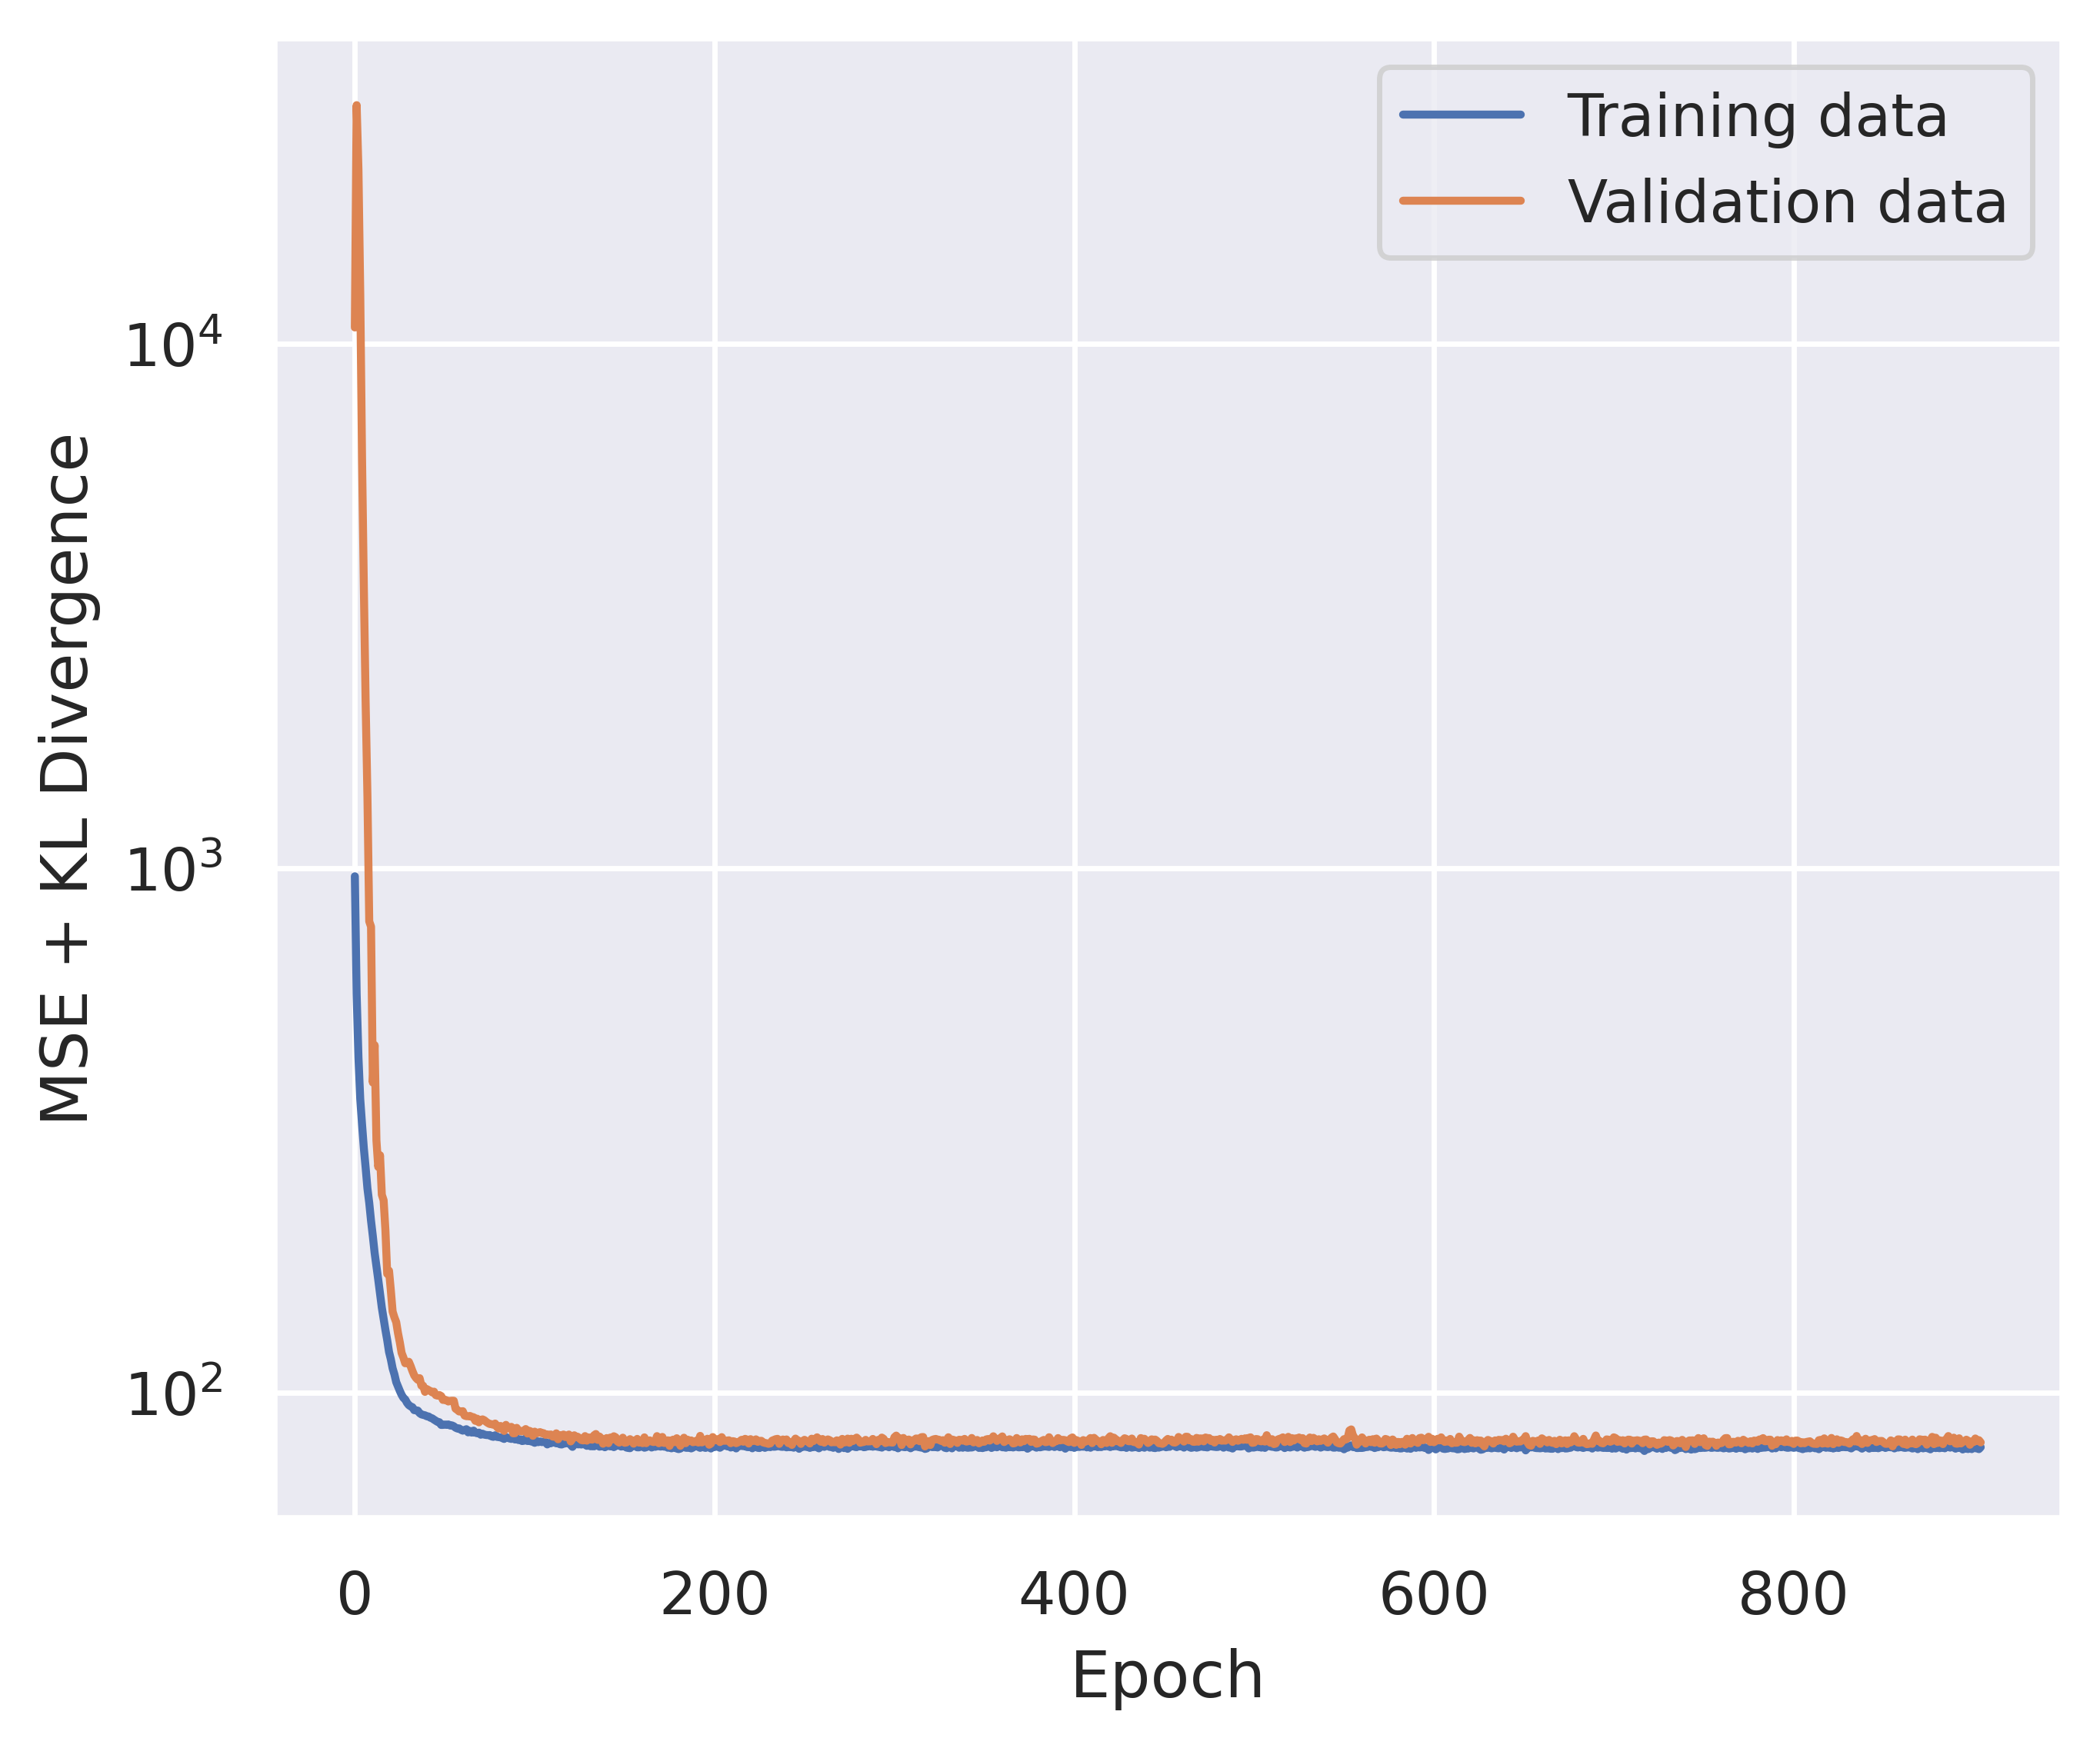

In [34]:
# plot and save the figure
save_path = pathlib.Path("../1.data-exploration/figures/training_curve.png")

plt.figure(figsize=(6, 5), dpi=500)
plt.plot(history_df["loss"], label="Training data")
plt.plot(history_df["val_loss"], label="Validation data")
plt.yscale("log")
plt.ylabel("MSE + KL Divergence")
plt.xlabel("Epoch")
plt.legend()
plt.savefig(save_path)
plt.show()

In [35]:
#Need to add code here to close those model

In [36]:
encoder = trained_vae.encoder_block["encoder"]
decoder = trained_vae.decoder_block["decoder"]

In [37]:
data_dir = "../0.data-download/data/"
model_df, dependency_df = load_data(data_dir, adult_or_pediatric="all")

In [38]:
train_init["train_or_test"] = train_init.apply(lambda _: "train", axis=1)
test_init["train_or_test"] = test_init.apply(lambda _: "test", axis=1)

In [39]:
# create a data frame of both test and train gene dependency data sorted by top 1000 highest gene variances
concat_frames = [train_init, test_init]
train_and_test = pd.concat(concat_frames).reset_index(drop=True)
train_and_test[["age_category", "sex"]] = train_and_test.age_and_sex.str.split(
    pat="_", expand=True
)
train_and_test_subbed = train_and_test.filter(gene_list, axis=1)
metadata_holder = []
metadata_holder = pd.DataFrame(metadata_holder)
metadata = metadata_holder.assign(
    DepMap_ID=train_and_test.DepMap_ID.astype(str),
    age_category=train_and_test.age_category.astype(str),
    sex=train_and_test.sex.astype(str),
    train_or_test=train_and_test.train_or_test.astype(str),
)
metadata

,DepMap_ID,age_category,sex,train_or_test
0,ACH-001623,Adult,Female,train
1,ACH-001715,Pediatric,Male,train
2,ACH-000588,Adult,Male,train
3,ACH-001212,Pediatric,Female,train
4,ACH-000222,Adult,Female,train
...,...,...,...,...
879,ACH-002298,Adult,Male,test
880,ACH-000213,Adult,Male,test
881,ACH-000181,Adult,Male,test
882,ACH-000237,Adult,Female,test


In [40]:
# Extract the latent space dimensions
latent_complete = np.array(encoder.predict(train_and_test_subbed)[2])

latent_df = pd.DataFrame(latent_complete)

# Create df of the latent space dimensions with the DepMap IDs added back in
extracted_col = metadata['DepMap_ID']

latent_df.insert(0, 'DepMap_ID', extracted_col)

# Save as a csv
latent_df_dir = pathlib.Path("./results/latent_df.csv")

latent_df.to_csv(latent_df_dir, index=False)

latent_df.head()

28/28 [==============================] - 0s 5ms/step


,DepMap_ID,0,1,2,3,4,5,6,7,8,...,90,91,92,93,94,95,96,97,98,99
0,ACH-001623,-0.898354,-1.478650,1.165028,0.072484,-0.127544,0.350056,-0.759941,0.326456,1.860474,...,-0.053927,-0.610516,1.156391,-1.846670,0.087763,-1.307595,-1.754402,-0.673624,0.299009,1.772073
1,ACH-001715,-1.283761,-0.538725,-0.650697,-0.402203,-0.112539,-0.116964,1.278960,-1.482963,1.665988,...,-0.942505,0.616119,-0.421655,0.813237,0.264797,-0.183722,-1.256154,-0.395816,-1.399832,1.003073
2,ACH-000588,0.999586,-1.536937,0.557497,-1.305320,-1.974564,1.499060,0.859937,0.587896,-1.913443,...,-0.338659,0.628391,0.433827,-1.155462,-0.163513,-0.961323,-1.020690,1.106140,2.579499,0.460202
3,ACH-001212,-0.093949,1.279794,-1.230453,0.644816,0.036216,-1.751655,-0.317827,0.572710,1.757316,...,-2.474081,1.015965,0.063775,-0.611607,-2.430818,-0.983140,1.248645,0.255144,0.206247,0.687188
4,ACH-000222,-0.868657,0.593087,0.970397,-0.889614,0.010682,-0.799127,-0.811274,1.542850,0.083178,...,-0.488548,-1.672516,-1.264257,-0.490987,-0.312677,-0.418062,-0.768016,0.912262,-1.007863,0.017274


In [41]:
# Extract the weights learned from the model, tranpose
weight_matrix = encoder.get_weights()[2]

weight_df = pd.DataFrame(weight_matrix)

# Save as csv to use for heatmap
weight_df_dir = pathlib.Path("./results/weight_matrix_encoder.csv")
weight_df.to_csv(weight_df_dir, index=False)
weight_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.004858,-0.071819,0.022239,-0.036087,0.004364,-0.126268,0.006842,-0.000695,0.067234,-0.017668,...,-0.079032,-0.064452,0.006963,-0.057158,-0.033359,-0.013473,-0.054367,-0.012734,-0.012163,-0.040028
1,0.009214,-0.030713,-0.117409,0.039585,0.180146,0.069179,-0.082029,-0.043286,0.041408,0.068156,...,-0.048653,0.060970,-0.038164,0.156056,-0.123474,-0.074970,0.118473,-0.020012,-0.041792,0.025773
2,0.019995,-0.054570,0.015781,0.068831,-0.086011,-0.026413,0.020017,-0.007749,0.031058,-0.031215,...,-0.037043,0.031091,0.048956,-0.074323,0.071925,0.010334,-0.100814,0.031670,-0.075555,0.046308
3,0.072013,-0.055428,0.001684,0.023022,-0.019924,-0.122359,0.006634,-0.015020,0.015102,-0.051711,...,0.002893,-0.064209,-0.003150,-0.148166,-0.049605,-0.055937,-0.124604,-0.070916,-0.047712,0.030486
4,0.009407,0.007505,-0.003729,-0.090936,-0.027123,-0.005849,0.069599,-0.001102,-0.002250,-0.020738,...,0.054073,0.056235,0.048485,-0.026636,0.029619,-0.011974,-0.047288,-0.005613,-0.017597,0.012419


In [42]:
# Transpose, add gene names back in, transpose again, reset the index, renumber the columns 
weight_df_T_df = weight_df.T

gene_weight_df = pd.DataFrame(data=weight_df_T_df.values, columns=subset_train_df.columns)

gene_weight_T_df = gene_weight_df.T

gw_reindex_df = gene_weight_T_df.reset_index()

gw_renumber_df = gw_reindex_df.rename(columns={x:y for x,y in zip(gw_reindex_df.columns,range(0,len(gw_reindex_df.columns)))})

# Remove numbers from gene name column
split_data_df = gw_renumber_df[0].str.split(" ", expand = True)

gene_name_df = split_data_df.iloc[:,:1]

trimmed_gene_weight_df = gw_renumber_df.iloc[:,1:]

final_gene_weights_df = gene_name_df.join(trimmed_gene_weight_df)

# Save as csv to use for GSEA
gene_weight_dir = pathlib.Path("./results/weight_matrix_gsea.csv")

final_gene_weights_df.to_csv(gene_weight_dir, index=False)

final_gene_weights_df.head()


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,100
0,GPX4,-0.004858,-0.071819,0.022239,-0.036087,0.004364,-0.126268,0.006842,-0.000695,0.067234,...,-0.079032,-0.064452,0.006963,-0.057158,-0.033359,-0.013473,-0.054367,-0.012734,-0.012163,-0.040028
1,CCND1,0.009214,-0.030713,-0.117409,0.039585,0.180146,0.069179,-0.082029,-0.043286,0.041408,...,-0.048653,0.060970,-0.038164,0.156056,-0.123474,-0.074970,0.118473,-0.020012,-0.041792,0.025773
2,EP300,0.019995,-0.054570,0.015781,0.068831,-0.086011,-0.026413,0.020017,-0.007749,0.031058,...,-0.037043,0.031091,0.048956,-0.074323,0.071925,0.010334,-0.100814,0.031670,-0.075555,0.046308
3,CDK6,0.072013,-0.055428,0.001684,0.023022,-0.019924,-0.122359,0.006634,-0.015020,0.015102,...,0.002893,-0.064209,-0.003150,-0.148166,-0.049605,-0.055937,-0.124604,-0.070916,-0.047712,0.030486
4,TXNRD1,0.009407,0.007505,-0.003729,-0.090936,-0.027123,-0.005849,0.069599,-0.001102,-0.002250,...,0.054073,0.056235,0.048485,-0.026636,0.029619,-0.011974,-0.047288,-0.005613,-0.017597,0.012419
